🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.27 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 3 stations (0.49 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.56 seconds).


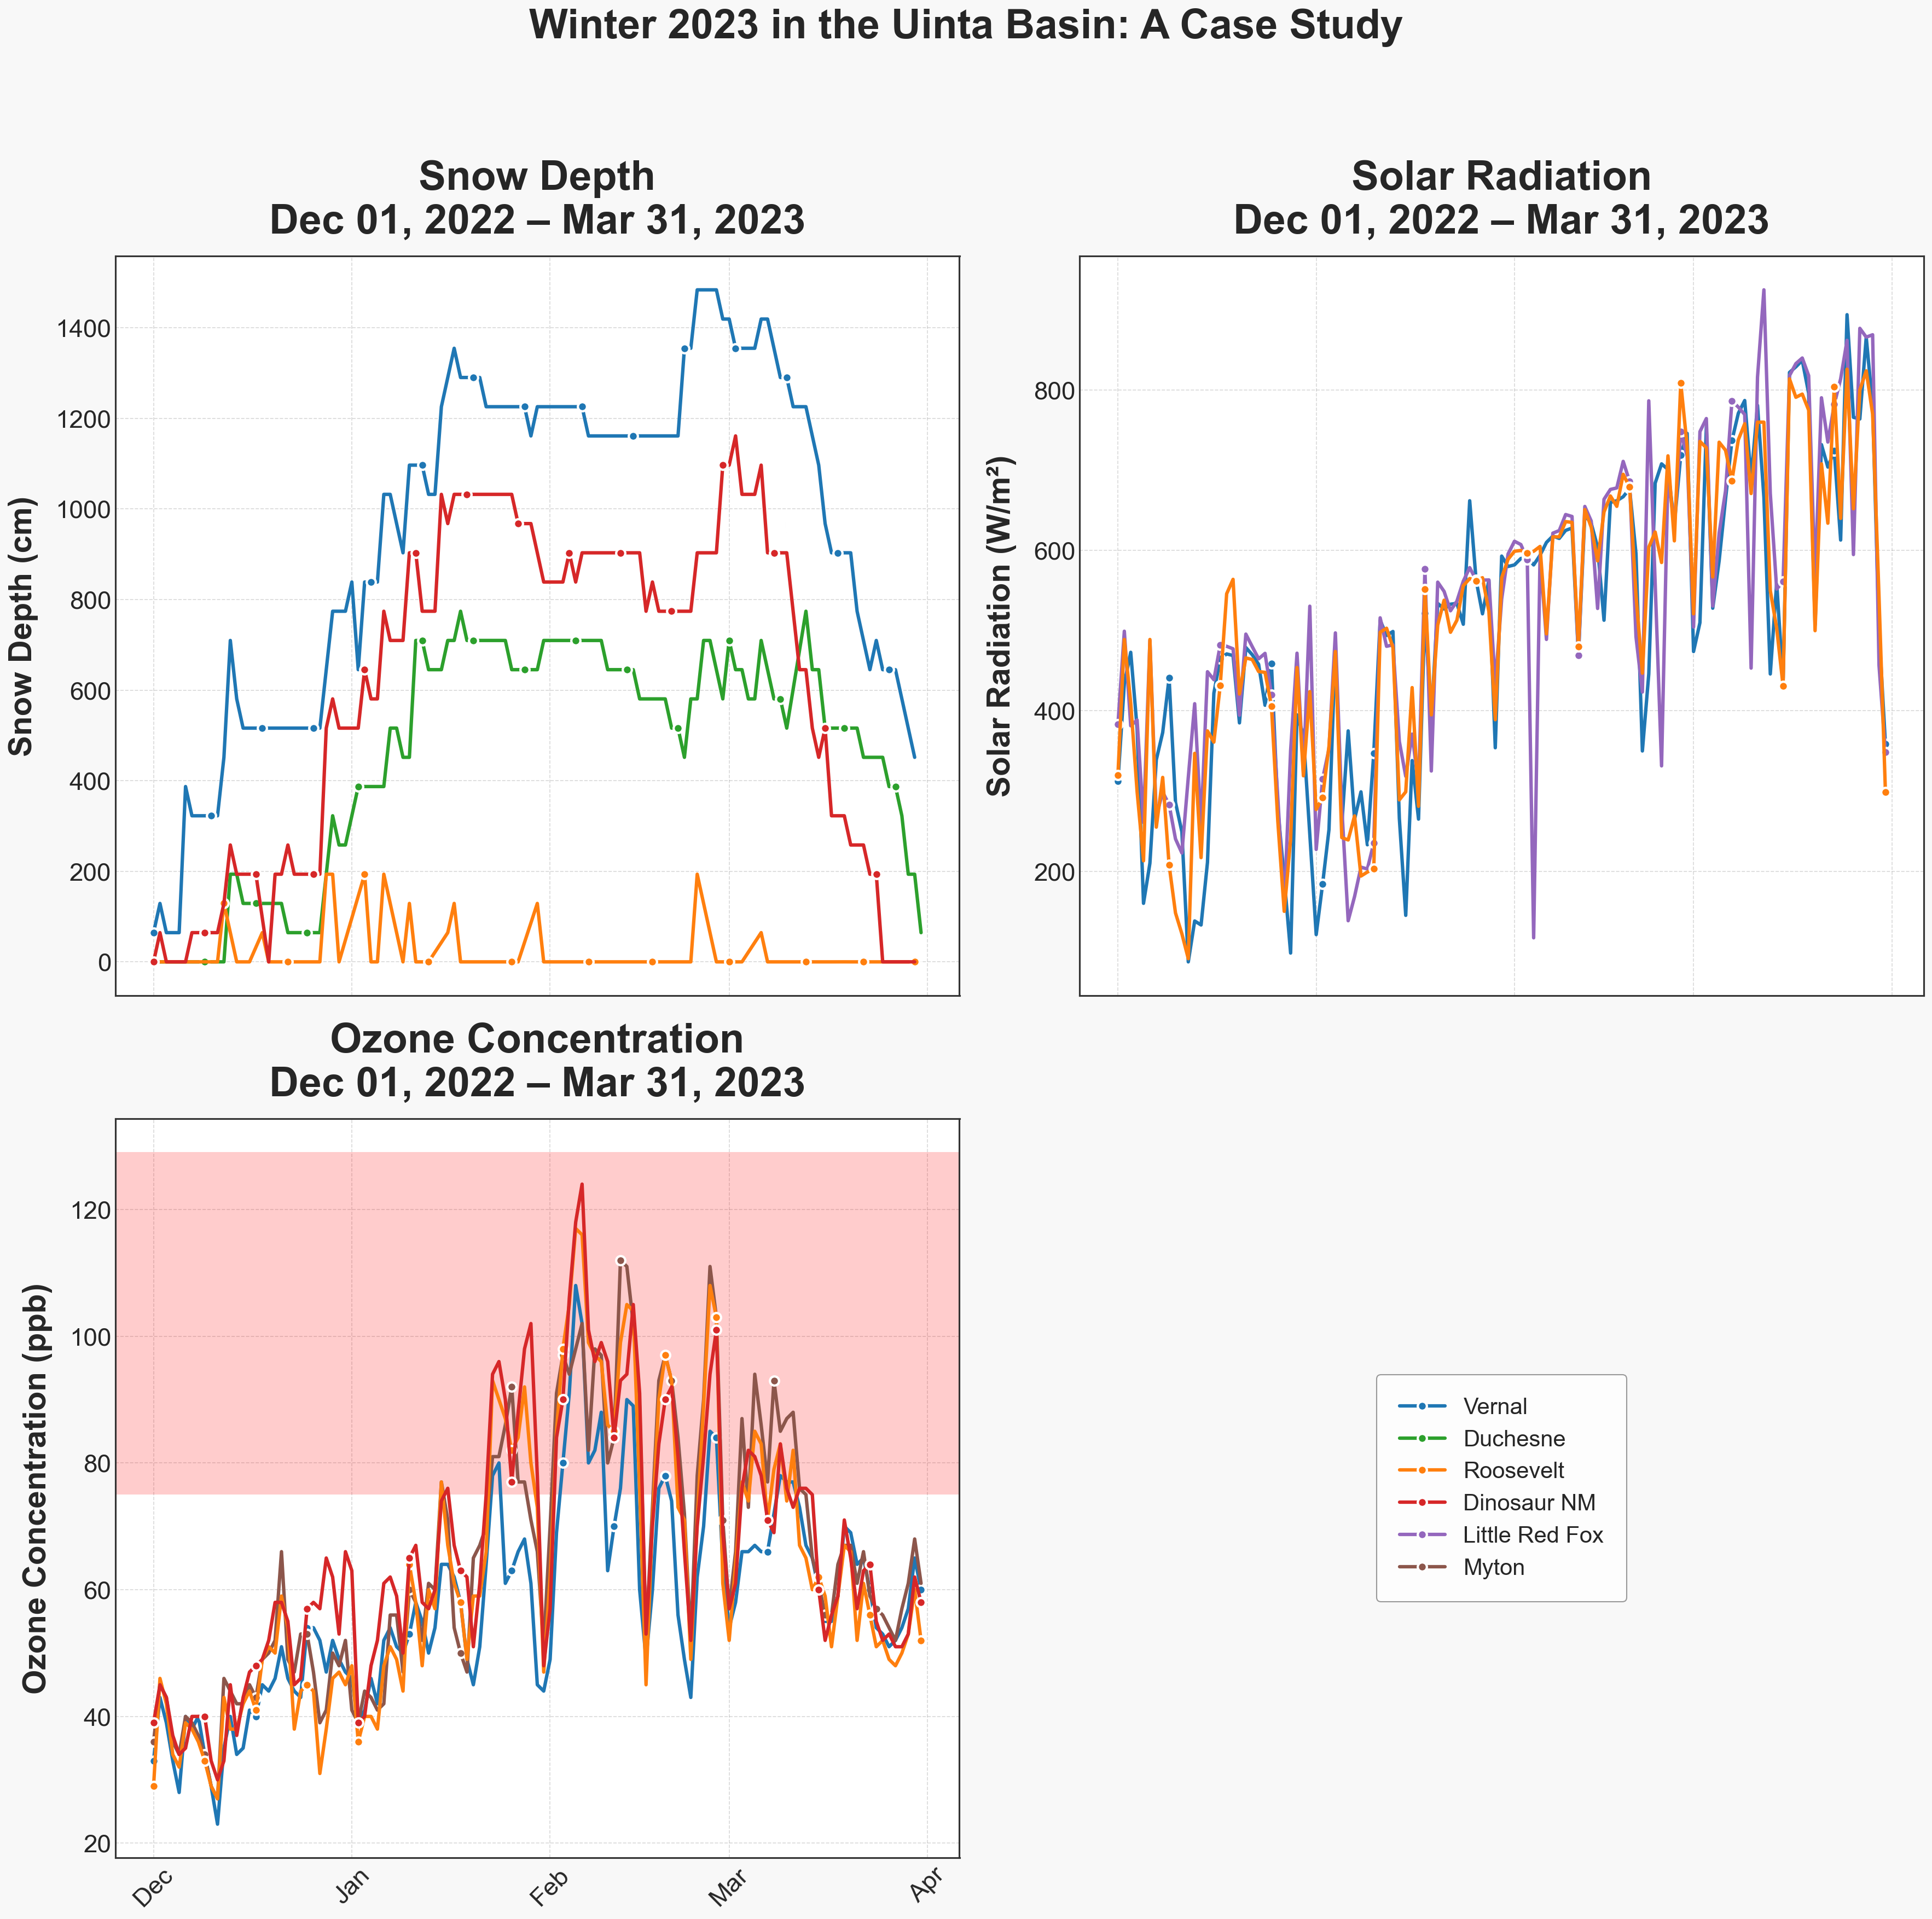

🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.22 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.53 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.59 seconds).


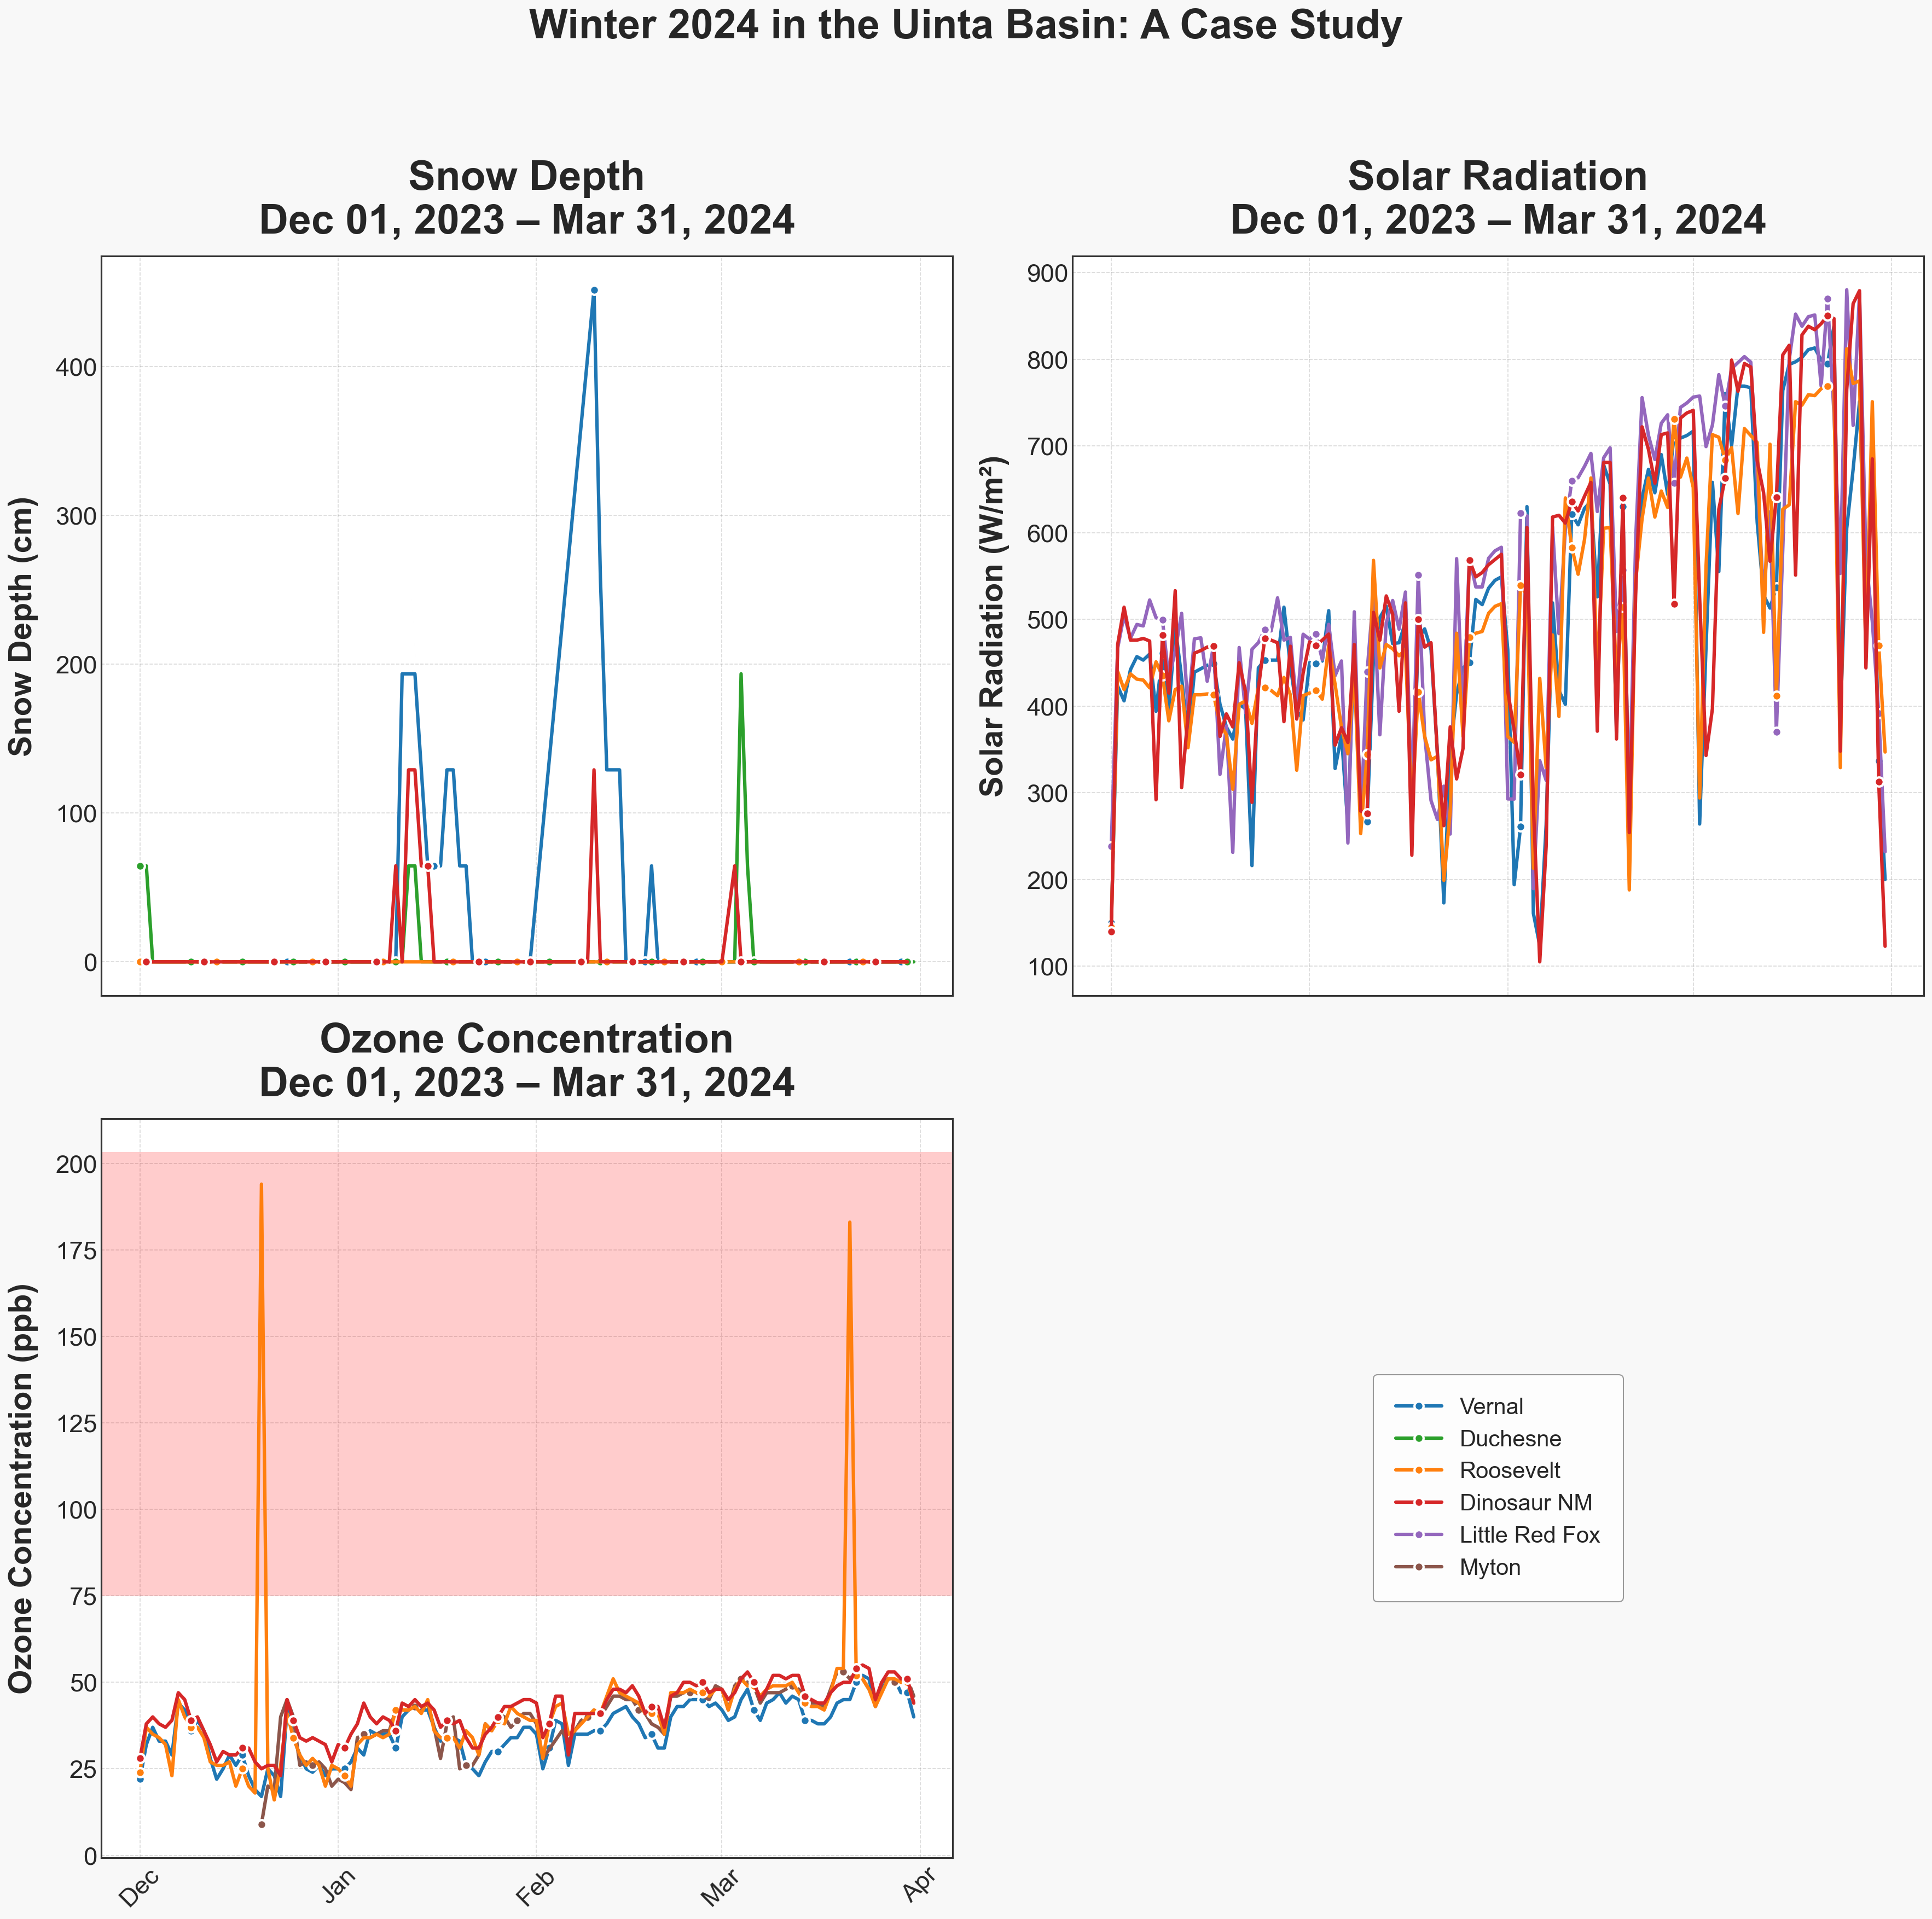

🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.19 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.49 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.46 seconds).


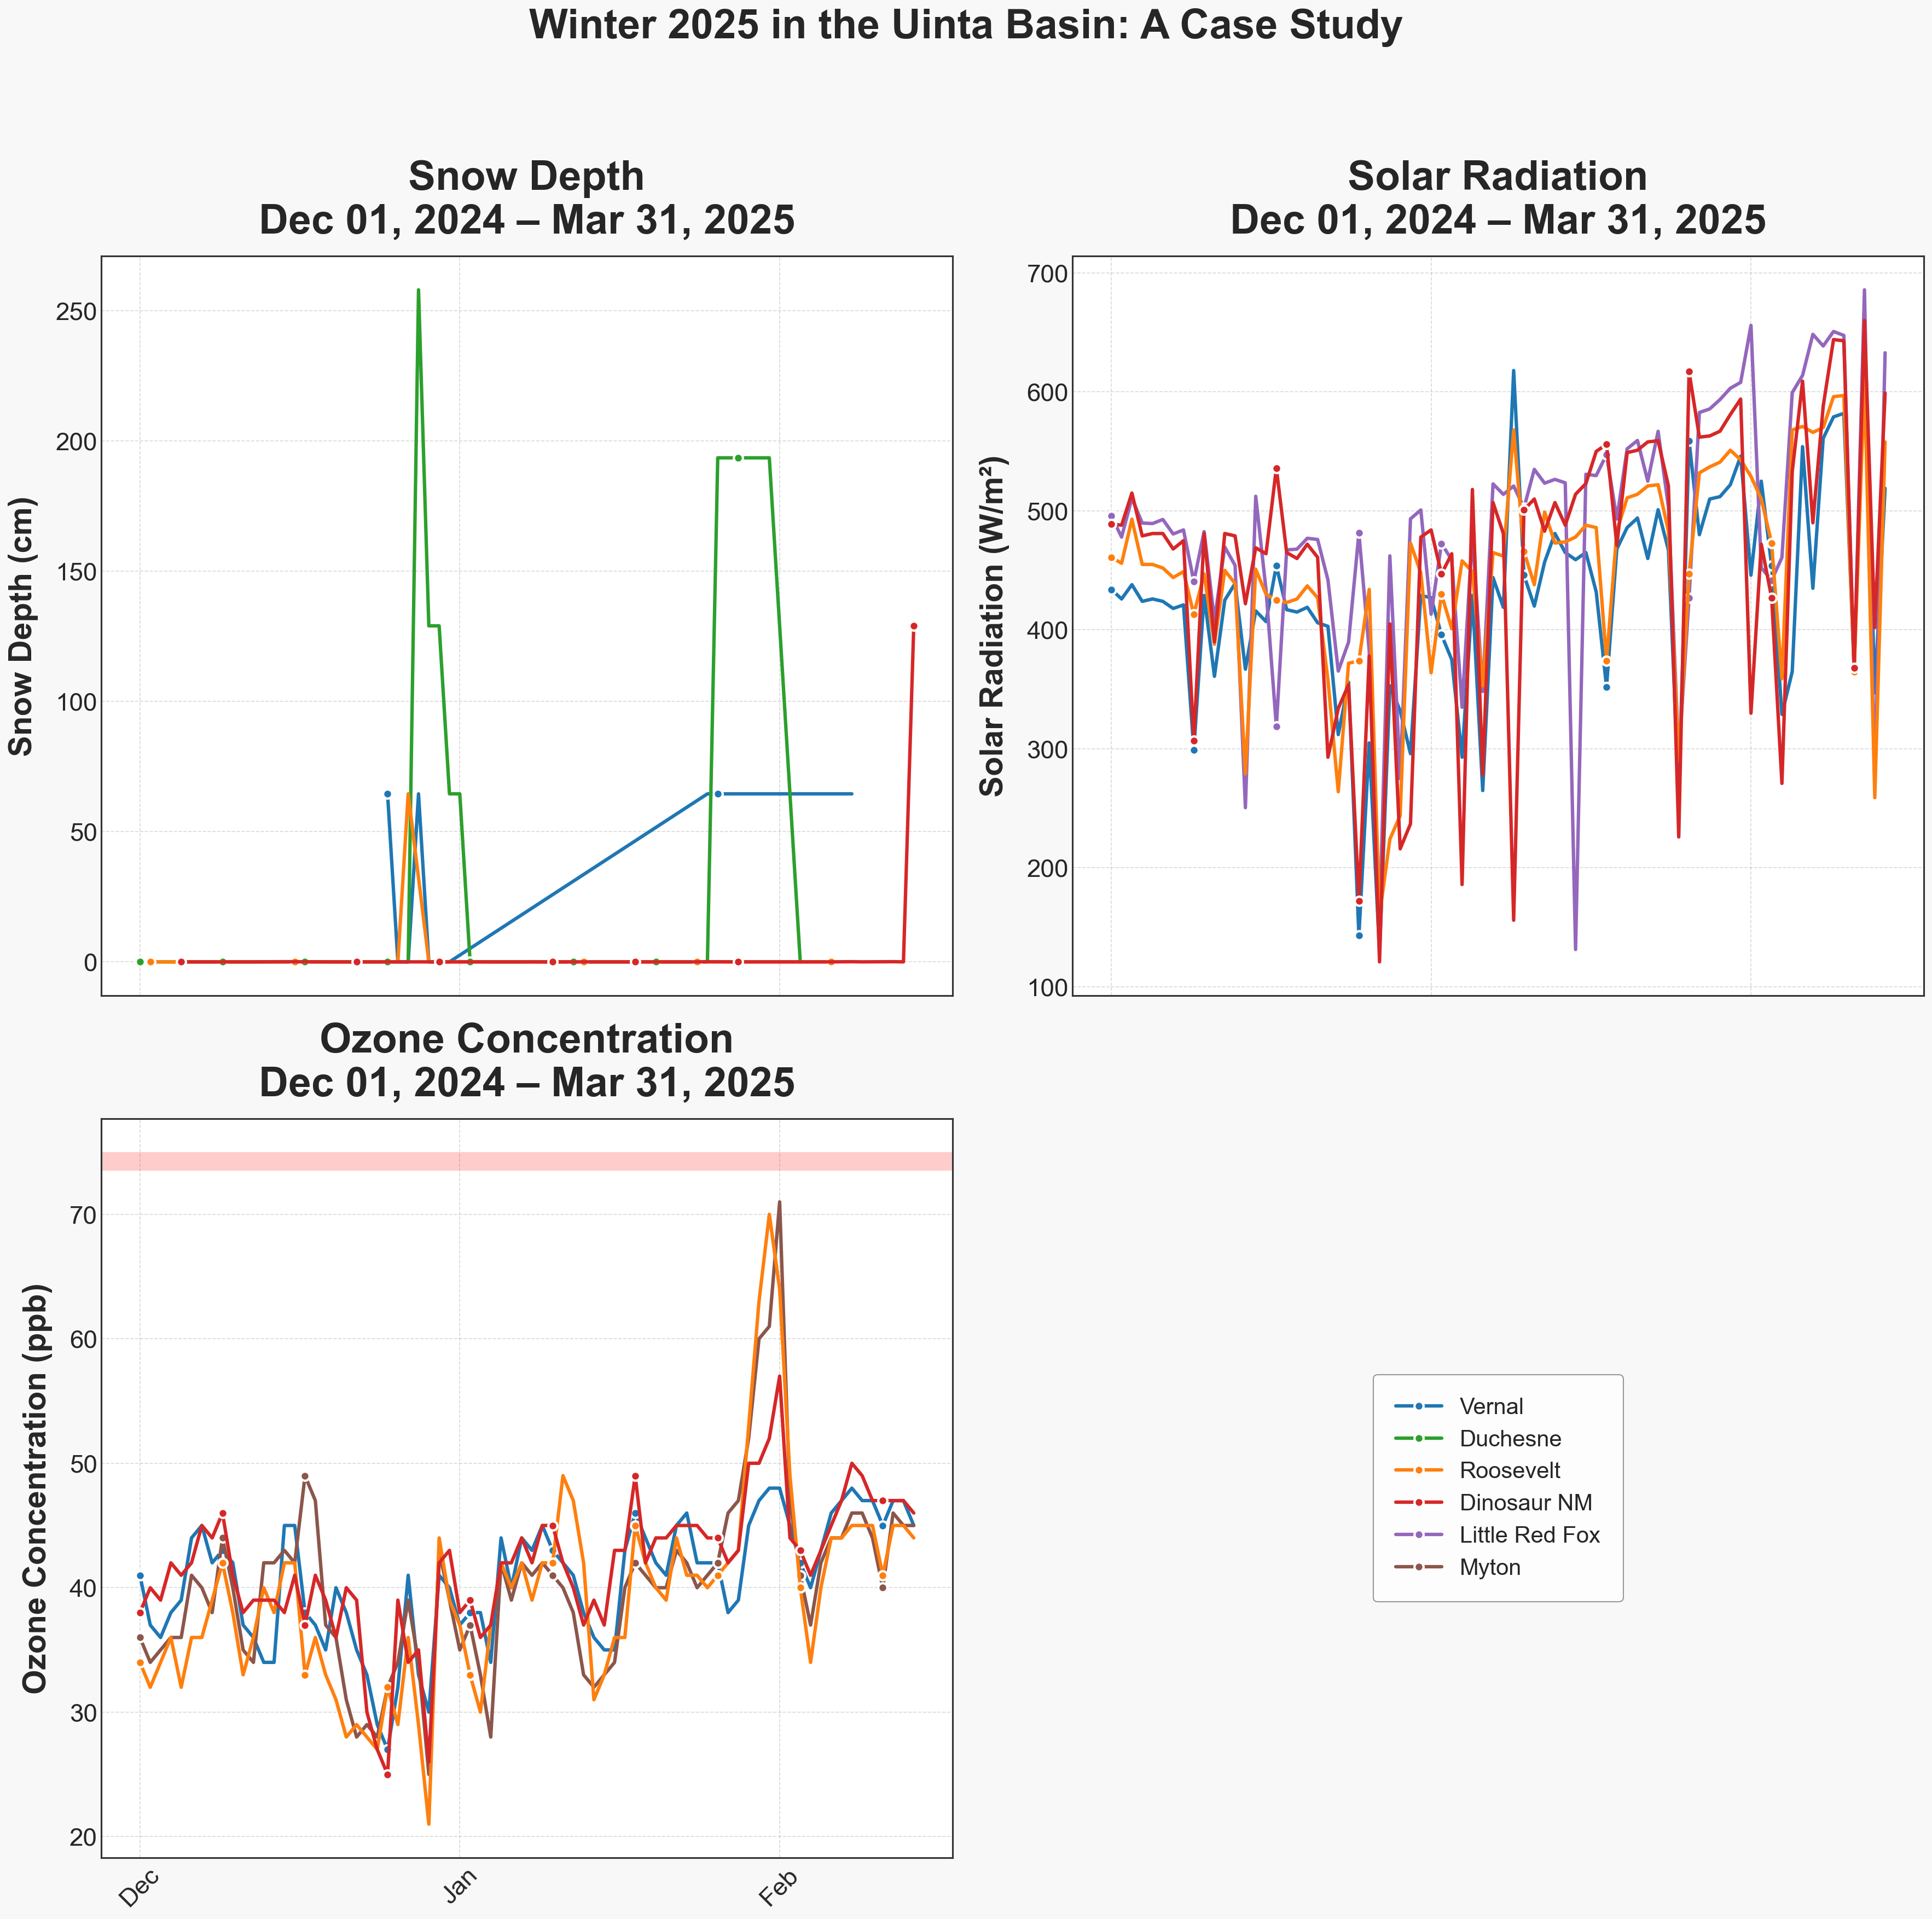

In [5]:
from datetime import datetime
from synoptic import TimeSeries
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import rcParams, lines
import matplotlib.dates as mdates

# --- Styling & Color Palette (Okabe & Ito) ---
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 22
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 28
rcParams['xtick.labelsize'] = 22
rcParams['ytick.labelsize'] = 22
rcParams['legend.fontsize'] = 20
rcParams['axes.linewidth'] = 1.5
plt.style.use('seaborn-v0_8-white')

# Colorblind-friendly hex codes
cb_colors = {
    'Vernal': '#1F77B4',
    'Duchesne': '#2CA02C',
    'Roosevelt': '#FF7F0E',
    'Dinosaur NM': '#D62728',
    'Little Red Fox': '#9467BD',
    'Myton': '#8C564B'
}

# --- API Token ---
token = 'YOUR_API_HERE'  # Replace with your valid token

# --- Define Winter Periods ---
# "Winter" is defined as Dec 1 to Mar 31.
winter_periods = {
    "2023": {"start": datetime(2022, 12, 1), "end": datetime(2023, 3, 31)},
    "2024": {"start": datetime(2023, 12, 1), "end": datetime(2024, 3, 31)},
    "2025": {"start": datetime(2024, 12, 1), "end": datetime(2025, 3, 31)}
}

# --- Variable Details ---
variables = {
    'snow_depth': {
        'title': 'Snow Depth',
        'ylabel': 'Snow Depth (cm)',  # conversion applied below
        'stations': {
            'COOPVELU1': {'name': 'Vernal',       'color': cb_colors['Vernal']},
            'COOPDSNU1': {'name': 'Duchesne',     'color': cb_colors['Duchesne']},
            'COOPROSU1': {'name': 'Roosevelt',    'color': cb_colors['Roosevelt']},
            'COOPDINU1': {'name': 'Dinosaur NM',  'color': cb_colors['Dinosaur NM']}
        }
    },
    'solar_radiation': {
        'title': 'Solar Radiation',
        'ylabel': 'Solar Radiation (W/m²)',
        'stations': {
            'QV4':    {'name': 'Vernal',        'color': cb_colors['Vernal']},
            'LRFU1':  {'name': 'Little Red Fox', 'color': cb_colors['Little Red Fox']},
            'QRS':    {'name': 'Roosevelt',     'color': cb_colors['Roosevelt']},
            'A3822':  {'name': 'Dinosaur NM',   'color': cb_colors['Dinosaur NM']}
        }
    },
    'ozone_concentration': {
        'title': 'Ozone Concentration',
        'ylabel': 'Ozone Concentration (ppb)',
        'stations': {
            'QV4':   {'name': 'Vernal',       'color': cb_colors['Vernal']},
            'A1388': {'name': 'Myton',        'color': cb_colors['Myton']},
            'QRS':   {'name': 'Roosevelt',    'color': cb_colors['Roosevelt']},
            'A3822': {'name': 'Dinosaur NM',  'color': cb_colors['Dinosaur NM']}
        }
    }
}
variable_keys = ['snow_depth', 'solar_radiation', 'ozone_concentration']

# --- Unified Legend Dictionary ---
legend_dict = {
    'Vernal': cb_colors['Vernal'],
    'Duchesne': cb_colors['Duchesne'],
    'Roosevelt': cb_colors['Roosevelt'],
    'Dinosaur NM': cb_colors['Dinosaur NM'],
    'Little Red Fox': cb_colors['Little Red Fox'],
    'Myton': cb_colors['Myton']
}

# --- Helper Function: Get Daily Maximum Values ---
def get_daily_max(token, stids, variable, start_date, end_date):
    ts = TimeSeries(
        token=token,
        stid=stids,
        vars=[variable],
        start=start_date,
        end=end_date
    )
    df = ts.df()
    rows = []
    for stid in stids:
        station_data = df.filter((pl.col('stid') == stid) & (pl.col('variable') == variable))
        station_data = station_data.filter(pl.col('value').is_not_null())
        if len(station_data) == 0:
            continue
        dates_list = station_data["date_time"].to_list()
        values_list = station_data["value"].to_list()
        day_max = {}
        for dt, val in zip(dates_list, values_list):
            day = dt.date()  # group by day
            day_max[day] = max(day_max.get(day, val), val)
        for d, v in day_max.items():
            rows.append({"date": d, "value": v, "stid": stid})
    return pd.DataFrame(rows)

# --- Loop Over Each Winter Period ---
for year_label, period in winter_periods.items():
    start_dt = period["start"]
    end_dt = period["end"]
    date_range_str = f"{start_dt.strftime('%b %d, %Y')} – {end_dt.strftime('%b %d, %Y')}"

    # Create a 2×2 grid: three plots + one legend panel.
    fig, axes = plt.subplots(2, 2, figsize=(24, 24), dpi=150, sharex=True)
    fig.patch.set_facecolor('#F8F8F8')

    ax_snow  = axes[0, 0]
    ax_solar = axes[0, 1]
    ax_ozone = axes[1, 0]
    ax_leg   = axes[1, 1]

    # Loop through each variable in the specified order.
    for var_key, ax in zip(variable_keys, [ax_snow, ax_solar, ax_ozone]):
        var_info = variables[var_key]
        stations = var_info['stations']

        # Fetch data for all stations for the current variable and period.
        ts = TimeSeries(
            token=token,
            stid=list(stations.keys()),
            vars=[var_key],
            start=start_dt,
            end=end_dt
        )
        df = ts.df()

        for stid, info in stations.items():
            station_data = df.filter((pl.col('stid') == stid) & (pl.col('variable') == var_key))
            station_data = station_data.filter(pl.col('value').is_not_null())
            if len(station_data) == 0:
                continue
            # Aggregate to daily maximum.
            dates_list = station_data["date_time"].to_list()
            values_list = station_data["value"].to_list()
            day_max = {}
            for dt, val in zip(dates_list, values_list):
                day = dt.date()
                day_max[day] = max(day_max.get(day, val), val)
            sorted_days = sorted(day_max.keys())
            dates = sorted_days
            values = [day_max[d] for d in sorted_days]

            # For snow depth, convert from inches to centimeters.
            if var_key == 'snow_depth':
                values = [v * 2.54 for v in values]

            ax.plot(
                dates,
                values,
                '-o',
                label=info['name'],
                color=info['color'],
                linewidth=3,
                markersize=8,
                markeredgecolor='white',
                markeredgewidth=2,
                markevery=8
            )

        # For ozone, add the EPA reference line (shade above 70 ppb)
        if var_key == 'ozone_concentration':
            ylim = ax.get_ylim()
            ax.axhspan(70, ylim[1], color='#FF0000', alpha=0.2, linewidth=0)

        ax.set_title(f"{var_info['title']}\n{date_range_str}", pad=20, fontweight='bold')
        ax.set_ylabel(var_info['ylabel'], labelpad=15, fontweight='bold')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.tick_params(axis='x', rotation=45, pad=5)
        ax.grid(True, linestyle='--', alpha=0.3, color='gray', which='major')
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('#333333')

    # Create unified legend in the bottom-right panel.
    ax_leg.axis('off')
    handles = [lines.Line2D([], [], color=color, marker='o', markersize=8,
                            markeredgecolor='white', markeredgewidth=2, linewidth=3)
               for name, color in legend_dict.items()]
    labels = list(legend_dict.keys())
    ax_leg.legend(handles, labels, loc='center', ncol=1,
                  frameon=True, facecolor='white', edgecolor='gray', borderpad=1)

    fig.suptitle(f"Winter {year_label} in the Uinta Basin: A Case Study",
                 fontsize=36, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.23 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.19 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.19 seconds).


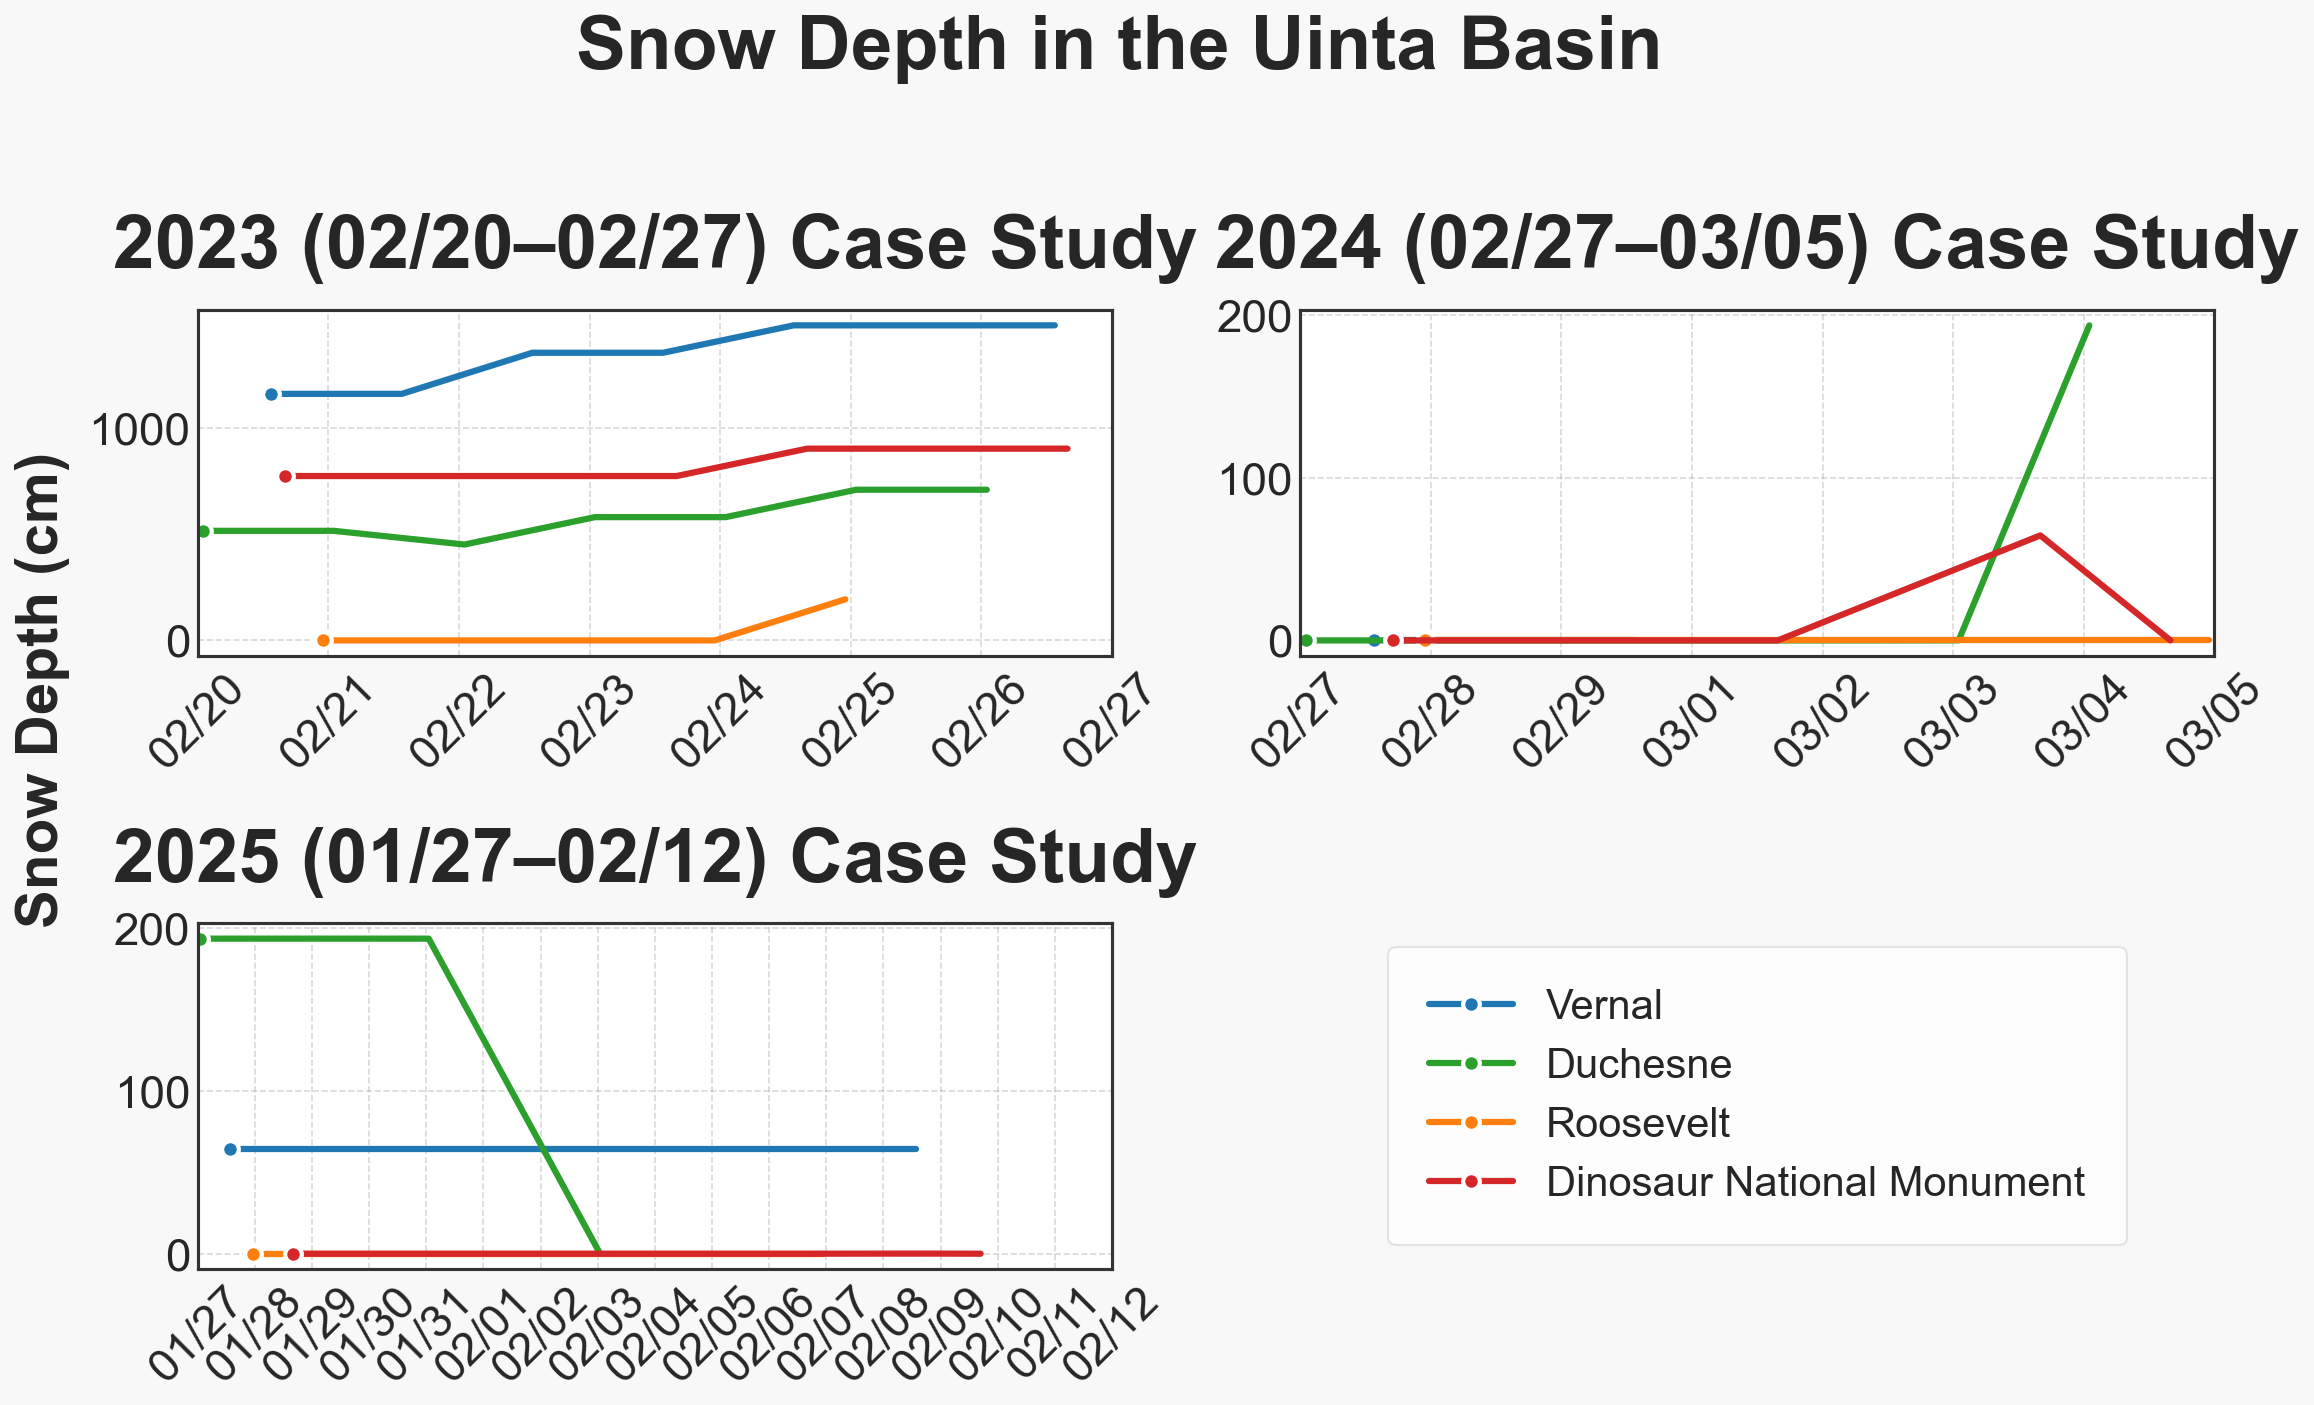

🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 3 stations (0.18 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.19 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.20 seconds).


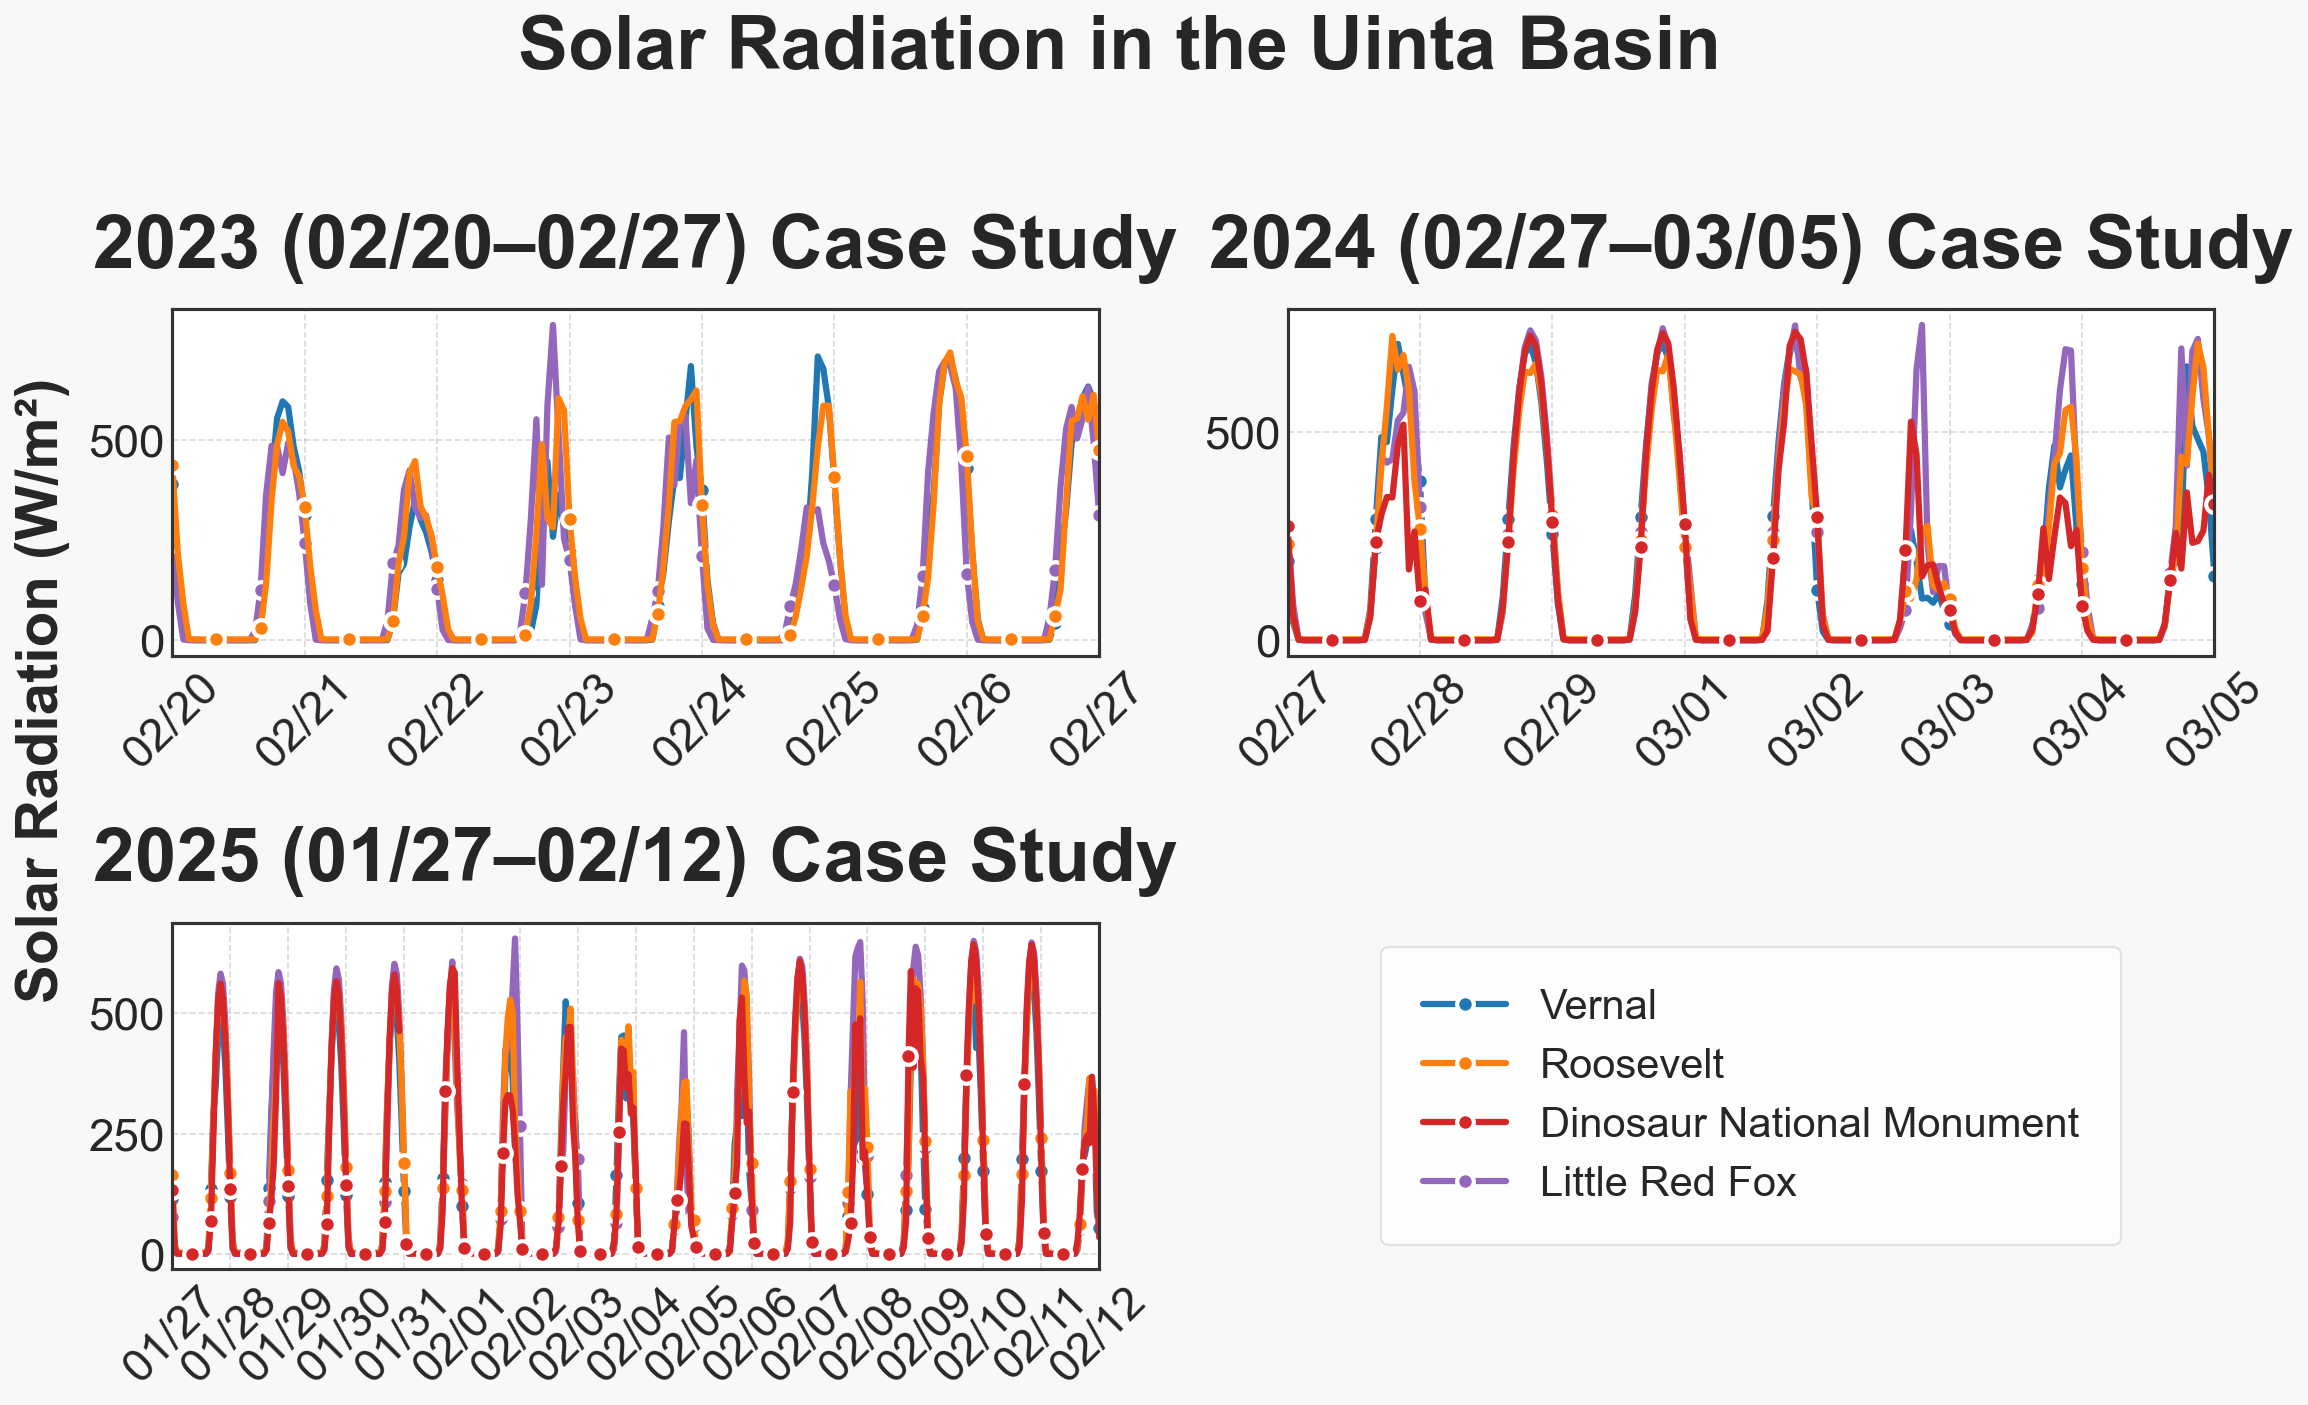

🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.19 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.21 seconds).
🚚💨 Speedy delivery from Synoptic's timeseries service.
📦 Received data from 4 stations (0.23 seconds).


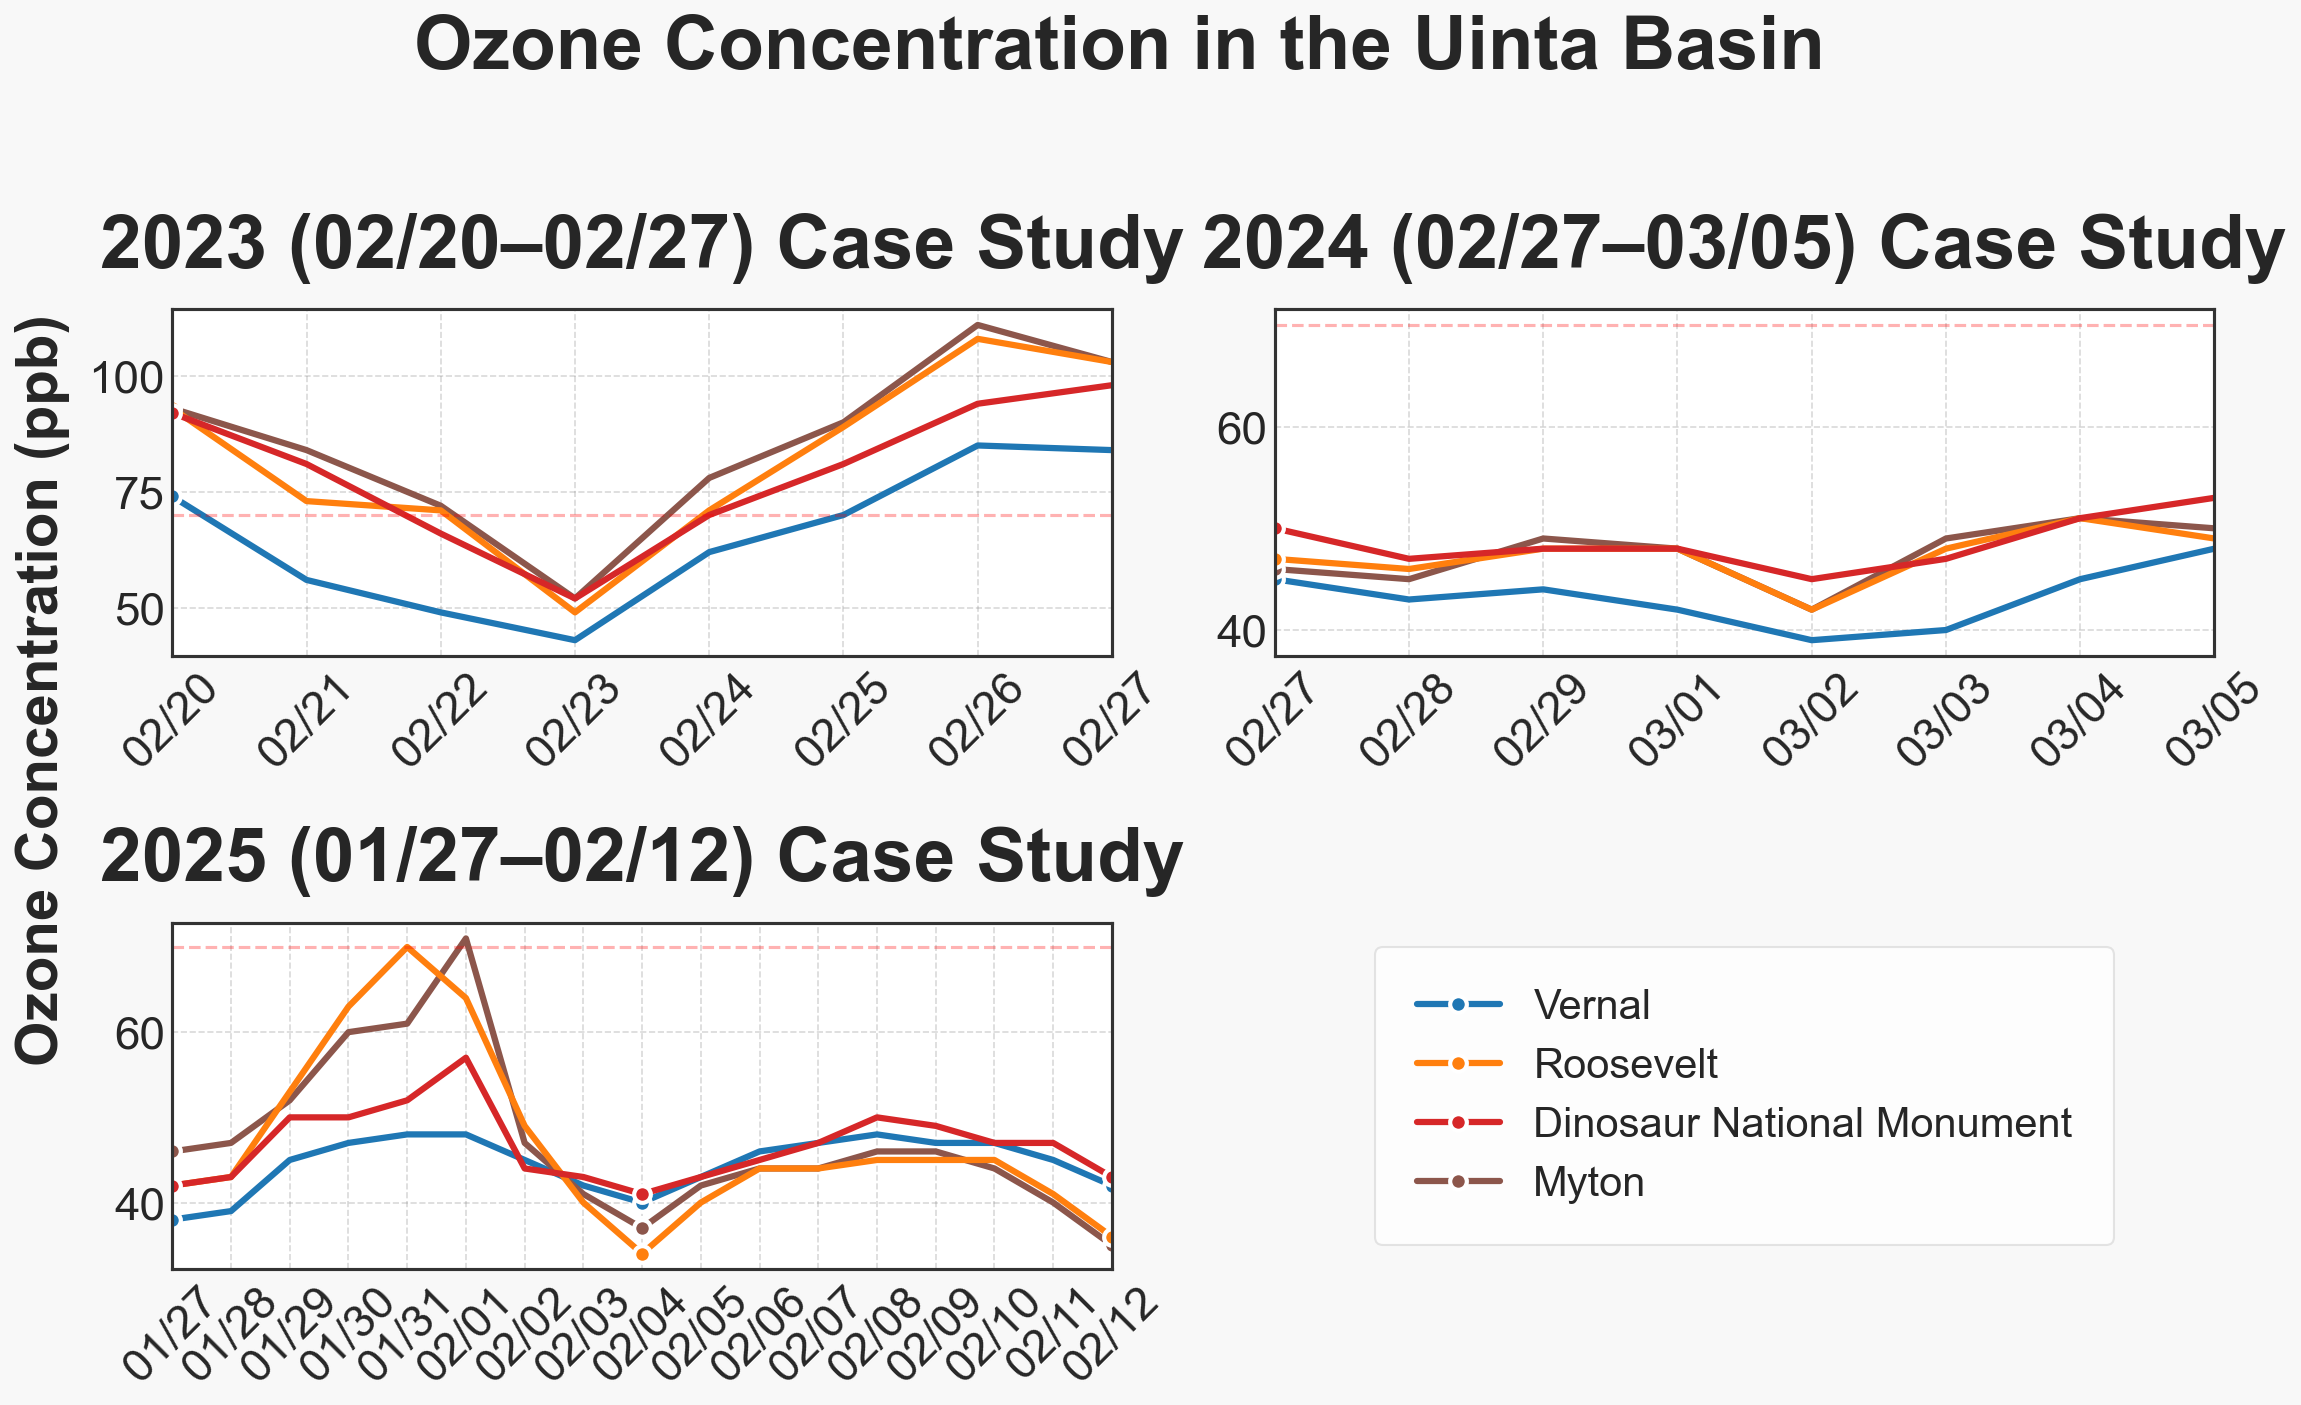

In [19]:
from datetime import datetime
from synoptic import TimeSeries
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import rcParams, lines
import matplotlib.dates as mdates
import pandas as pd

# --- Basic Styling ---
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica Neue', 'Helvetica', 'Arial']
rcParams['font.size'] = 22
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 28
rcParams['xtick.labelsize'] = 22
rcParams['ytick.labelsize'] = 22
rcParams['legend.fontsize'] = 20
rcParams['axes.linewidth'] = 1.5
rcParams['axes.edgecolor'] = '#333333'
plt.style.use('seaborn-v0_8-white')

# --- API Token ---
token = 'YOUR_API_HERE'  # Replace with your valid token

# --- Case Studies ---
case_studies = [
    {'year': '2023', 'start': datetime(2023, 2, 20), 'end': datetime(2023, 2, 27)},
    {'year': '2024', 'start': datetime(2024, 2, 27), 'end': datetime(2024, 3, 5)},
    {'year': '2025', 'start': datetime(2025, 1, 27), 'end': datetime(2025, 3, 2)}  # 2025 will be overridden to Feb 12
]

# --- Variable Details ---
variables = {
    'snow_depth': {
        'title': 'Snow Depth in the Uinta Basin',
        'ylabel': 'Snow Depth (cm)',  # conversion: inches -> cm
        'stations': {
            'COOPVELU1': {'name': 'Vernal', 'color': '#1F77B4'},
            'COOPDSNU1': {'name': 'Duchesne', 'color': '#2CA02C'},
            'COOPROSU1': {'name': 'Roosevelt', 'color': '#FF7F0E'},
            'COOPDINU1': {'name': 'Dinosaur National Monument', 'color': '#D62728'}
        }
    },
    'solar_radiation': {
        'title': 'Solar Radiation in the Uinta Basin',
        'ylabel': 'Solar Radiation (W/m²)',
        'stations': {
            'QV4': {'name': 'Vernal', 'color': '#1F77B4'},
            'LRFU1': {'name': 'Little Red Fox', 'color': '#9467BD'},
            'QRS': {'name': 'Roosevelt', 'color': '#FF7F0E'},
            'A3822': {'name': 'Dinosaur National Monument', 'color': '#D62728'}
        }
    },
    'ozone_concentration': {
        'title': 'Ozone Concentration in the Uinta Basin',
        'ylabel': 'Ozone Concentration (ppb)',
        'stations': {
            'QV4': {'name': 'Vernal', 'color': '#1F77B4'},
            'A1388': {'name': 'Myton', 'color': '#8C564B'},
            'QRS': {'name': 'Roosevelt', 'color': '#FF7F0E'},
            'A3822': {'name': 'Dinosaur National Monument', 'color': '#D62728'}
        }
    }
}
variable_keys = ['snow_depth', 'solar_radiation', 'ozone_concentration']

# --- Unified Legend Dictionary ---
legend_dict = {
    'Vernal': '#1F77B4',
    'Duchesne': '#2CA02C',
    'Roosevelt': '#FF7F0E',
    'Dinosaur National Monument': '#D62728',
    'Little Red Fox': '#9467BD',
    'Myton': '#8C564B'
}

# --- Helper Function: Get Daily Maximum for Ozone (No Forward Fill) ---
def get_daily_max(token, stids, variable, start_date, end_date):
    ts = TimeSeries(token=token, stid=stids, vars=[variable],
                    start=start_date, end=end_date)
    df = ts.df()
    rows = []
    for stid in stids:
        station_data = df.filter((pl.col('stid') == stid) & (pl.col('variable') == variable))
        station_data = station_data.filter(pl.col('value').is_not_null())
        if len(station_data) == 0:
            continue
        day_max = {}
        for dt, val in zip(station_data["date_time"].to_list(), station_data["value"].to_list()):
            d = dt.date()
            day_max[d] = max(day_max.get(d, val), val)
        for d, v in day_max.items():
            rows.append({"date": d, "value": v, "stid": stid})
    return pl.DataFrame(rows)

# --- Main Loop: Loop Over Each Variable ---
for var_key in variable_keys:
    var_info = variables[var_key]

    # Create a 2×2 grid: three subplots for the case studies, one for the legend.
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), dpi=150)
    fig.patch.set_facecolor('#F8F8F8')

    # Data subplots: positions [0,0], [0,1], [1,0]
    ax_list = [axes[0,0], axes[0,1], axes[1,0]]
    ax_leg = axes[1,1]
    ax_leg.axis('off')

    # Set to track which stations appear (for legend)
    used_stations = set()

    for idx, case in enumerate(case_studies):
        ax = ax_list[idx]
        start_dt = case['start']
        # For 2025, override end date to Feb 12th.
        if case['year'] == '2025':
            plot_end_dt = datetime(2025, 2, 12)
        else:
            plot_end_dt = case['end']
        year_label = case['year']

        # If ozone, use daily max aggregation; otherwise, use raw data.
        if var_key == 'ozone_concentration':
            stids = list(var_info['stations'].keys())
            df_var = get_daily_max(token, stids, var_key, start_dt, plot_end_dt)
        else:
            ts = TimeSeries(token=token, stid=list(var_info['stations'].keys()),
                            vars=[var_key], start=start_dt, end=plot_end_dt)
            df_raw = ts.df()
            df_var = df_raw

        for stid, info in var_info['stations'].items():
            st_data = df_var.filter(pl.col("stid") == stid)
            if len(st_data) == 0:
                continue
            used_stations.add(info['name'])

            if var_key == 'ozone_concentration':
                dates = st_data["date"].to_list()
                values = st_data["value"].to_list()
            else:
                dates = st_data["date_time"].to_list()
                values = st_data["value"].to_list()
                if var_key == 'snow_depth':
                    # For raw snow depth, filter out None values and convert to cm.
                    filtered = [(d, v * 2.54) for d, v in zip(dates, values) if v is not None]
                    if filtered:
                        dates, values = zip(*filtered)
                        dates, values = list(dates), list(values)
                    else:
                        dates, values = [], []

            ax.plot(
                dates,
                values,
                '-o',
                label=info['name'],
                color=info['color'],
                linewidth=3,
                markersize=8,
                markeredgecolor='white',
                markeredgewidth=2,
                markevery=8
            )

        # For ozone, add the EPA reference line at 70 ppb.
        if var_key == 'ozone_concentration':
            ax.axhline(y=70, color='#FF0000', linestyle='--', alpha=0.3, linewidth=1.5)

        # Format x-axis: daily ticks.
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.set_xlim([start_dt, plot_end_dt])
        ax.tick_params(axis='x', rotation=45, pad=5)
        ax.grid(True, linestyle='--', alpha=0.3, color='gray', which='major')
        ax.set_facecolor('white')
        ax.set_axisbelow(True)

        # Subplot title: e.g. "2023 (02/20–02/27) Case Study"
        date_str = f"{start_dt.strftime('%m/%d')}–{plot_end_dt.strftime('%m/%d')}"
        ax.set_title(f"{year_label} ({date_str}) Case Study", pad=20, fontweight='bold')
        ax.set_ylabel("")
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('#333333')

    # Add a common y-axis label.
    fig.text(0.04, 0.5, var_info['ylabel'], va='center', rotation='vertical',
             fontsize=28, fontweight='bold')

    # Build unified legend only for stations that appear.
    used_legend = {name: legend_dict[name] for name in legend_dict if name in used_stations}
    handles = [lines.Line2D([], [], color=color, marker='o', markersize=8,
                             markeredgecolor='white', markeredgewidth=2, linewidth=3)
               for name, color in used_legend.items()]
    labels = list(used_legend.keys())
    ax_leg.legend(handles, labels, loc='center', ncol=1,
                  frameon=True, facecolor='white', edgecolor='#DDDDDD', borderpad=1)

    # Overall figure title.
    fig.suptitle(var_info['title'], fontsize=36, fontweight='bold', y=0.95)

    plt.tight_layout(rect=[0.05, 0, 1, 0.93])
    plt.show()
